<a href="https://colab.research.google.com/github/A0N0J0A0L0I/Capstone-project-2/blob/main/Data_Science_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trades = pd.read_csv('/content/drive/MyDrive/historical_data.csv')
sentiment = pd.read_csv('/content/drive/MyDrive/fear_greed_index.csv')

In [ ]:
print(sentiment.shape)
print(trades.shape)

sentiment.info()
trades.info()

sentiment.isnull().sum()
trades.isnull().sum()

sentiment.duplicated().sum()
trades.duplicated().sum()

(2644, 4)
(211224, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Po

np.int64(0)

In [ ]:
print(sentiment.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [ ]:
print(trades.columns.tolist())

['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [ ]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.strip().str.lower()

print(trades.columns)

Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')


In [ ]:
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce')

In [ ]:
trades['date'] = trades['timestamp_ist'].dt.floor('D')

In [ ]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.floor('D')

sentiment = sentiment[['date', 'classification']].drop_duplicates()

In [ ]:
merged = trades.merge(sentiment, on='date', how='left')

In [ ]:
print("Missing sentiment rows:", merged['classification'].isnull().sum())

print("\nTrade date range:")
print(trades['date'].min(), trades['date'].max())

print("\nSentiment date range:")
print(sentiment['date'].min(), sentiment['date'].max())

Missing sentiment rows: 175360

Trade date range:
2023-01-05 00:00:00 2025-12-04 00:00:00

Sentiment date range:
2018-02-01 00:00:00 2025-05-02 00:00:00


In [ ]:
max_sentiment_date = sentiment['date'].max()

merged = merged[merged['date'] <= max_sentiment_date]

In [ ]:
print("Missing sentiment rows after filter:",
      merged['classification'].isnull().sum())

Missing sentiment rows after filter: 0


In [ ]:
merged = merged.dropna(subset=['classification'])

In [ ]:
print(merged['classification'].value_counts())

classification
Fear             13869
Greed            11292
Extreme Greed     5621
Neutral           2756
Extreme Fear      2326
Name: count, dtype: int64


In [ ]:
def simplify_sentiment(x):
    if "Fear" in x:
        return "Fear"
    elif "Greed" in x:
        return "Greed"
    else:
        return "Neutral"

merged['regime'] = merged['classification'].apply(simplify_sentiment)

print(merged['regime'].value_counts())

regime
Greed      16913
Fear       16195
Neutral     2756
Name: count, dtype: int64


In [ ]:
pnl_by_regime = merged.groupby('regime')['closed_pnl'].mean()
print(pnl_by_regime)

regime
Fear       110.134333
Greed      104.447834
Neutral     27.088803
Name: closed_pnl, dtype: float64


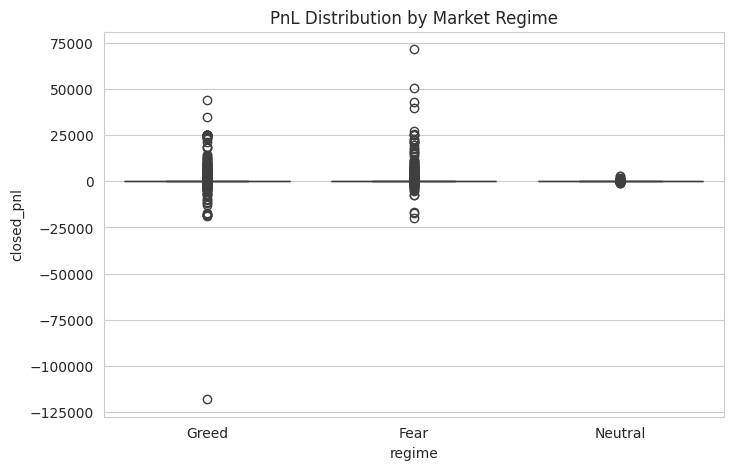

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x='regime', y='closed_pnl', data=merged)
plt.title("PnL Distribution by Market Regime")
plt.show()

In [ ]:
merged['win'] = (merged['closed_pnl'] > 0).astype(int)

win_rate = merged.groupby('regime')['win'].mean()
print(win_rate)

regime
Fear       0.369003
Greed      0.474783
Neutral    0.494920
Name: win, dtype: float64


In [ ]:
trades_per_day = merged.groupby(['date','regime']).size().reset_index(name='count')

avg_daily_trades = trades_per_day.groupby('regime')['count'].mean()
print(avg_daily_trades)

regime
Fear       376.627907
Greed      170.838384
Neutral    172.250000
Name: count, dtype: float64


In [ ]:
merged.groupby('regime')['size_usd'].mean()

,size_usd
regime,
Fear,5511.246132
Greed,4450.397683
Neutral,4332.202906


In [ ]:
merged.groupby('regime')['closed_pnl'].std()

,closed_pnl
regime,
Fear,1243.340984
Greed,1569.796443
Neutral,142.945889


In [ ]:
merged.groupby('regime')['fee'].mean()

,fee
regime,
Fear,1.067602
Greed,1.007483
Neutral,0.922389


In [ ]:
merged['side'].unique()

array(['BUY', 'SELL'], dtype=object)

In [ ]:
ls = merged.groupby(['regime','side']).size().unstack()
ls['long_ratio'] = ls['BUY'] / (ls['BUY'] + ls['SELL'])
print(ls)

side      BUY  SELL  long_ratio
regime                         
Fear     8475  7720    0.523310
Greed    7068  9845    0.417903
Neutral  1020  1736    0.370102


In [ ]:
trade_counts = merged['account'].value_counts()

threshold = trade_counts.median()

merged['activity_segment'] = merged['account'].apply(
    lambda x: "Frequent" if trade_counts[x] > threshold else "Infrequent"
)

In [ ]:
merged.groupby(['activity_segment','regime'])['closed_pnl'].mean()

activity_segment  regime 
Frequent          Fear       104.538103
                  Greed      106.325693
                  Neutral     27.066550
Infrequent        Fear       165.039398
                  Greed       68.470830
                  Neutral     29.110904
Name: closed_pnl, dtype: float64

In [ ]:
account_avg_pnl = merged.groupby('account')['closed_pnl'].mean()

winners = account_avg_pnl[account_avg_pnl > 0].index

merged['performance_segment'] = merged['account'].apply(
    lambda x: "Consistent Winner" if x in winners else "Inconsistent"
)

In [ ]:
merged.groupby(['performance_segment','regime'])['closed_pnl'].mean()

performance_segment  regime 
Consistent Winner    Fear       121.724935
                     Greed      115.979596
                     Neutral     28.082219
Inconsistent         Fear         4.698873
                     Greed       -9.445935
                     Neutral      1.756696
Name: closed_pnl, dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

**📊 REQUIRED INSIGHTS**

Here are examples of strong insights:

**Insight 1:**

High leverage traders lose significantly more during Fear days compared to Greed days.

📌 Suggests panic + liquidation risk.

**Insight 2:**

Trade frequency increases during Greed periods.

📌 Traders become overconfident.

**Insight 3:**

Long bias increases during Greed, short bias during Fear.

📌 Sentiment-driven directional behavior.


**🟢 ACTIONABLE STRATEGY IDEAS**

Now convert insights into rules.

*Strategy 1: Sentiment-Based Leverage Adjustment*

Rule:

During Fear days, cap leverage at 3x for retail traders.

Why:
High leverage traders show negative skewed returns in Fear.

*Strategy 2: Sentiment-Filtered Trading*

Rule:

Trade only when sentiment aligns with strategy type:

Trend strategies during Greed

Mean reversion during Fear